### vhead and KB test 2023/01/04~
- dual head nonlinear encoder: (class,var)
- random bit encoder: Nbit->1bit, n-sample
- variance loss
----
- __used in a paper, KB-equation__
----

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import itertools

/Users/na/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
class RBE(object):
    # binary random bit encoder
    def __init__(self,N):
        # N, size of bitstrings
        self.N=N

    def gen_all_bits(self,tensor=True):
        bits=np.zeros((2**self.N,1,self.N))
        for i in range(2**self.N):
            b=format(i,'b')
            bits[i,0,-len(b):]=list(map(int,b))
        bits=bits.astype(np.float32)
        if tensor is True: bits=torch.from_numpy(bits)
        return bits

    def gen_random_bits(self,n):
        # generate n bitstrings with a single template.
        # value x=1 if x<p else 0
        bits=(np.random.rand(n,1,self.N)<0.5).astype(np.float32)
        ans=(np.random.rand(n,1)<0.5).astype(np.float32)
        return bits,ans

    def return_bitans(self,bits,ans,tensor=True):
        if tensor is True:
            bits=torch.from_numpy(bits)
            ans=torch.from_numpy(ans)
        return bits,ans

    def gen_RBE(self,n,tensor=True):
        b,a=self.gen_random_bits(n)
        return self.return_bitans(b,a)

In [78]:
class FCN(nn.Module):
    def __init__(self,size=12,in_channel=1,ksize=3,out_channel=3,layerN=3,padding='same'):
        super(FCN,self).__init__()
        # backbone: simple 1D-convolution
        self.conv0=nn.Conv1d(in_channel,out_channel,ksize,padding=padding)
        self.convs=[nn.Conv1d(out_channel,out_channel,ksize,padding=padding) for i in range(layerN-1)]
        # feature output from the backbone input-size x out_channel
        self.size=size
        self.out_channel=out_channel
        self.in_channel=in_channel
        self.layerN=layerN
        self.fc1=nn.Linear(size*out_channel,1)
        self.fc2=nn.Linear(size*out_channel,1)
        self.S=nn.Sigmoid()

    def forward(self,x):
        x=F.elu(self.conv0(x))
        for c in self.convs: x=F.elu(c(x))
        x = x.view(-1,self.size*self.out_channel)
        x0,x1=self.fc1(x),self.fc2(x)
        mu,sig=self.S(x0),self.S(x1)
        return mu,sig

class Loss2(nn.Module):
    def __init__(self): # パラメータの設定など初期化処理を行う
        super(Loss2, self).__init__()

    def forward(self, mu, sig, Y): # モデルの出力と正解データ
        # log( 1/( sig*sqrt(2*pi) * exp( -(x-mu)^2/(2*sig^2) ) )
        # -log(sig)-log(pi)/2-(x-mu)^2/(2*sig^2)
        # -log(sig)-mse/(2*sig^2) + C
        err=mu-Y
        #print(err.shape,mu.shape,Y.shape)
        #mse=torch.sum(torch.square(mu-Y),1,keepdim=True)
        loss2=torch.mean(torch.log(sig)+err*err/(2*sig*sig))
        return loss2,torch.mean(err*err),torch.mean(sig*sig)

class Loss1(nn.Module):
    def __init__(self): # パラメータの設定など初期化処理を行う
        super(Loss1, self).__init__()

    def forward(self, mu, sig, Y): # モデルの出力と正解データ
        # log( 1/(2*sig) * exp( -|x-mu|/sig ) )
        # -log(sig) - |x-mu|/sig + C
        # -log(sig) - L1/sig
        err=torch.abs(mu-Y)
        loss1=torch.mean(torch.log(sig)+err/sig)
        return loss1,torch.mean(err*err),torch.mean(sig*sig*2)

In [392]:
Ps=[]

In [401]:
learning_rate=0.1
momentum=0.0
size=8
layerN=3
RBE_sample=1

rbe=RBE(size)
xall=rbe.gen_all_bits()
X,Y=rbe.gen_RBE(RBE_sample)
fcn=FCN(size=size,layerN=layerN)

optimizer=opt.SGD(fcn.parameters(),lr=learning_rate,momentum=momentum)
mseloss=nn.MSELoss()
L1loss=nn.L1Loss()
Lloss=Loss1()
Gloss=Loss2()

Finished Training


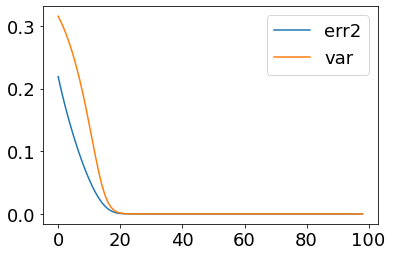

In [402]:
emx=500
#print(rbe.get_interaction_RBE(b=1.0))
pv=[]
whist=[]
preds=[]
for e in range(emx):
    optimizer.zero_grad()

    mu,s=fcn(X)
    preds.append([mu.item(),s.item()])
    #preds.append([mu.detach().cpu().numpy(),s.detach().cpu().numpy()])

    #L,err2,var=Lloss(mu,s,Y)
    L,err2,var=Gloss(mu,s,Y*0)
    pv.append([L.item(),err2.item(),var.item()])
    L.backward()
    #err2.backward()
    optimizer.step()
    #if e%100==99:
    #    m,s=fcn(xall)
    #    w=estimate_w(X,Y,xall,m,s).tolist()
    #    whist.append([e]+w)

Ps.append(preds)
print('Finished Training')
pv=np.array(pv)
#ew=np.array(whist)
#plt.plot(pv[:,0],label='loss')
plt.plot(pv[:,1],label='err2')
plt.plot(pv[:,2],label='var')
#plt.plot(ew[:,0],ew[:,1],label='w')
plt.legend()
plt.show()

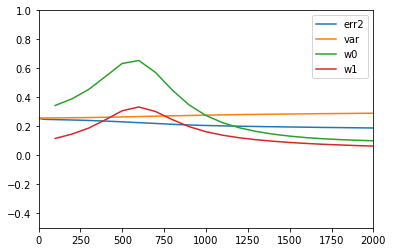

In [352]:
plt.plot(pv[:,1],label='err2')
plt.plot(pv[:,2],label='var')
plt.plot(ew[:,0],ew[:,1],label='w0')
plt.plot(ew[:,0],ew[:,2],label='w1')
plt.ylim(-0.5,1.0)
plt.xlim(0,2000)
plt.legend()
plt.show()

----
__kernel size analysis__

In [285]:
m,s=fcn(xall)

In [321]:
def tonumpy(x): return x.to('cpu').detach().numpy().copy()

def make_dict(X,Y):
    xn,yn=tonumpy(X),tonumpy(Y)
    xy_dict={}
    for i in range(xn.shape[0]):
        key=tuple(xn[i,0,:].tolist())
        val=yn[i,0]
        xy_dict[key]=xy_dict.get(key,[])+[val]
    return xy_dict

def get_H(k1,k2): return np.sum(np.abs(np.array(k1)-np.array(k2))).astype(np.int32)

def get_mdict(xy_dict,hmx=1):
    mdict={}
    for k1,v1 in xy_dict.items():
        vh={0:v1,1:[]}
        for k2,v2 in xy_dict.items():
            h=get_H(k1,k2)
            if 0<h<=hmx: vh[h]=vh.get(h,[])+v2
        mdict[k1]=vh
    return mdict

def estimate_w(X,Y,xall,m,s):
    xy_data=make_dict(X,Y)
    xy_pred=make_dict(xall,m)
    xy_dataM=get_mdict(xy_data,hmx=3)
    xs_pred=make_dict(xall,s)
    ws=[]
    for k,v in xy_dataM.items():
        pm,ps=xy_pred[k][0],xs_pred[k][0]
        #sum(v[0])+w*np.sum(v[1])=pm|V[0]|+w*pm|V[1]|
        #(a+b*w)^2->0
        #a=sum(v[0])-pm|V[0]|
        #b=np.sum(v[1])-pm|V[1]|
        #2b(a+b*w)=2ab+2bbw
        ws.append([np.sum(v[i])-pm*len(v[i]) for i in range(len(v))])
        #a=np.sum(v[i])-pm*len(v[i])
        #b=np.sum(v[1])-pm*len(v[1])
        #ws.append([a,b])
        #w=(np.sum(v[0])-pm*len(v[0]))/(pm*len(v[1])-np.sum(v[1]))
        #ws.append(w)
    ws=np.array(ws)
    pI=np.linalg.pinv(ws[:,1:])
    return -np.matmul(pI,ws[:,0])
    #A,B=np.sum(ws[:,0]),np.sum(ws[:,1])
    #return A/B

estimate_w(X,Y,xall,m,s)

array([0.00528227, 0.1176221 , 0.01125557])

----
__massive test__


In [216]:
learning_rate=0.1
momentum=0.0
size=8
layerN=3
RBE_sample_mx=300
emx=2000
rbe=RBE(size)
xall=rbe.gen_all_bits()

loss_all=[]
for N in range(50,RBE_sample_mx):
    X,Y=rbe.gen_RBE(N)
    fcn=FCN(size=size,layerN=layerN)
    optimizer=opt.SGD(fcn.parameters(),lr=learning_rate,momentum=momentum)
    mseloss=nn.MSELoss()
    L1loss=nn.L1Loss()
    Lloss=Loss1()
    Gloss=Loss2()
    
    loss_vect=[]
    for e in range(emx):
        optimizer.zero_grad()
        mu,s=fcn(X)

        #L,err2,var=Lloss(mu,s,Y)
        L,err2,var=Gloss(mu,s,Y)
        loss_vect.append([L.item(),err2.item(),var.item()])
        L.backward()
        optimizer.step()
    loss_all.append(loss_vect)
    print(N,abs(loss_vect[-1][1]-loss_vect[-1][2]))

50 0.0017491132020950317
51 0.1549815833568573
52 0.1468372941017151
53 0.10106618702411652
54 0.0015801787376403809
55 0.00886949896812439
56 0.2325691282749176
57 0.2826916426420212
58 0.0022732317447662354
59 0.0028897225856781006
60 nan
61 0.002718508243560791
62 nan
63 0.006339177489280701
64 0.015812695026397705
65 nan
66 0.00025281310081481934
67 0.0014506727457046509
68 0.085184246301651
69 0.06786277890205383
70 0.0004961192607879639
71 0.00010316073894500732
72 0.0016430020332336426
73 0.0018396228551864624
74 0.00023439526557922363
75 0.00046521425247192383
76 0.00264836847782135
77 0.002422019839286804
78 0.0017432719469070435
79 0.0015699714422225952
80 0.0012184381484985352
81 0.0076496899127960205
82 0.001013636589050293
83 0.0006026923656463623
84 1.65402889251709e-05
85 0.005096316337585449
86 3.3348798751831055e-05
87 0.0024018585681915283
88 0.0010750293731689453
89 0.000692903995513916
90 0.00014822185039520264
91 0.001290053129196167
92 0.0003564804792404175
93 0.0

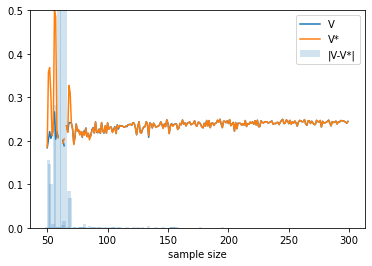

In [230]:
def plot_loss_all(los_all,xmn=50,xmx=300,errV=100):
    Lall=np.array(los_all)
    err=np.abs(Lall[:,-1,1]-Lall[:,-1,2])
    idx=np.isnan(err)
    err[idx]=errV
    plt.bar(range(xmn,xmx),err,label='|V-V*|',alpha=0.2,width=3)
    plt.plot(range(xmn,xmx),Lall[:,-1,1],label='V')
    plt.plot(range(xmn,xmx),Lall[:,-1,2],label='V*')
    plt.ylim(0,0.5)
    #plt.ylabel('V-V*')
    plt.xlabel('sample size')
    plt.legend()
    plt.show()

plot_loss_all(loss_all)

----
__gaussian loss visualization__

/var/folders/82/ysn2wf8x1x9dt6md300frm700000gn/T/ipykernel_28444/1329136622.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(sg)-(x-mu)*(x-mu)/(2*sg*sg)
/var/folders/82/ysn2wf8x1x9dt6md300frm700000gn/T/ipykernel_28444/1329136622.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(sg)-(x-mu)*(x-mu)/(2*sg*sg)
/var/folders/82/ysn2wf8x1x9dt6md300frm700000gn/T/ipykernel_28444/1329136622.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(sg)-(x-mu)*(x-mu)/(2*sg*sg)


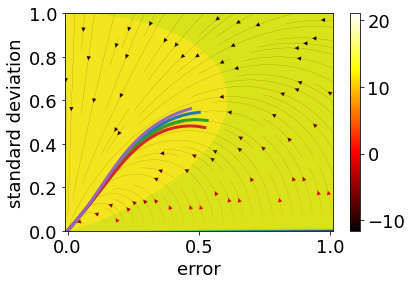

In [420]:
def gauss_dist(x,mu,sg):
    xx=(x-mu)/sg
    return np.exp(-xx*xx/2)/sg
    return np.exp(-xx*xx/2)/(sg*np.sqrt(2*np.pi))

def log_gauss(x,mu,sg):
    return -np.log(sg)-(x-mu)*(x-mu)/(2*sg*sg)

sgs=np.linspace(0,1,num=300)
mus=np.linspace(-0.05,1.05,num=300)
M=np.zeros((len(sgs),len(mus)))
# -log(sig)-mse/(2*sig^2) + C
for (i,s),(j,m) in itertools.product(enumerate(sgs),enumerate(mus)):
    #M[i,j]=np.log(gauss_dist(0,m,s))
    M[i,j]=log_gauss(0,m,s)

#plt.imshow(mus,sgs,M)


plt.rcParams["font.size"] = 18

plt.contourf(mus,sgs,M,levels=30)
#plt.colorbar()
dm,ds=0.5*(mus[1]-mus[0]),0.5*(sgs[1]-sgs[0])

U,V=M[:-1,1:]-M[:-1,:-1],M[1:,:-1]-M[:-1,:-1]

plt.streamplot(mus[:-1]+dm,sgs[:-1]+ds,U,V,color=np.log(U*U+V*V),cmap=plt.cm.hot,density=1.0,linewidth=0.1)
plt.colorbar()
plt.xlim(-0.01,1.01)
plt.xlabel('error')
plt.ylabel('standard deviation')
#seed_points=np.array([[0,0.1,0.2,0.3,0.4],[0.8,0.25,0.25,0.25,0.25]])
#plt.streamplot(mus[:-1]+dm,sgs[:-1]+ds,U,V,color=np.log(U*U+V*V),cmap=plt.cm.hot,start_points=seed_points.T)
#plt.colorbar()
for ps in Ps:
    xy=np.array(ps)
    plt.plot(xy[:,0],xy[:,1],lw=3)
#plt.subplots_adjust(left=0.2,bottom=0.2)
#plt.savefig('point_training.eps')
#plt.close()

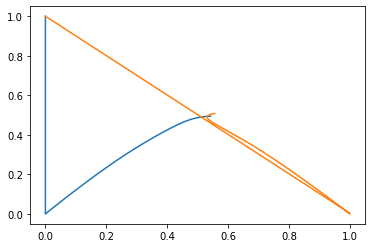

In [378]:
for ps in Ps:
    xy=np.array(ps)
    #print(xy.shape)
    for i in range(xy.shape[2]):
        plt.plot(xy[:,0,i,0],xy[:,1,i,0])
plt.show()